In [35]:
import warnings
warnings.filterwarnings("ignore")

import argparse
import shutil
import os
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from ae import AE, NAE
from modules import DeConvNet2, ConvNet2FC, FC_supermask_encode, FC_supermask_decode, FC_supermask_encode_nonstochastic, FC_supermask_decode_nonstochastic, FC_original_encode, FC_original_decode
from leaveout_dataset import MNISTLeaveOut
from tqdm import tqdm

from sklearn.metrics import roc_auc_score
from utils import roc_btw_arr
from torchvision.utils import make_grid, save_image
from torchvision.transforms import ToTensor

from tensorboardX import SummaryWriter




In [98]:
device = 1
leave_out = 1
batch_size = 128
sparsity = 0.9999

In [99]:
'''build model for RE loss weight training'''
encoder = FC_original_encode(device = device) #ConvNet2FC(1, z_dim, nh=8, nh_mlp=1024, out_activation='linear')
decoder = FC_original_decode(device = device) #DeConvNet2(z_dim, 1, nh=8, out_activation='sigmoid')
        
model = NAE(encoder, decoder)
model.cuda(device);

In [100]:
model.load_state_dict(torch.load(f'./snip_results/testing/sparsitiy_{sparsity}_leaveout_{leave_out}/snip_pruned.pkl'))

<All keys matched successfully>

In [101]:
def predict(m, dl, device, flatten=False):
    l_result = []
    for x, _ in dl:
        with torch.no_grad():
            if flatten:
                x = x.view(len(x), -1)
            pred = m.predict(x.cuda(device)).detach().cpu()
        l_result.append(pred)
    return torch.cat(l_result)


'''load dataset'''
ds = MNISTLeaveOut('dataset', [leave_out], split='training', transform=ToTensor(), download=True)
in_train_dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=10)
ds = MNISTLeaveOut('dataset', [leave_out], split='validation', transform=ToTensor(), download=True)
in_val_dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=10)
ds = MNISTLeaveOut('dataset', [leave_out], split='evaluation', transform=ToTensor(), download=True)
in_test_dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=10)

in_digits = list(set(list(range(10)))-set([leave_out]))
ds = MNISTLeaveOut('dataset', in_digits, split='validation', transform=ToTensor(), download=True)
out_val_dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=10)
ds = MNISTLeaveOut('dataset', in_digits, split='evaluation', transform=ToTensor(), download=True)
out_test_dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=10)



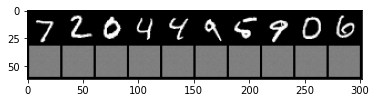

In [102]:
'''check inlier reconstruction'''
test_data = torch.stack([in_test_dl.dataset[i][0] for i in range(10)])
recon = model.reconstruct(test_data.reshape(-1,784).cuda(device)).detach().cpu()
recon = torch.clamp(recon.view(len(recon), 1, 28, 28), 0, 1)
x_and_recon = torch.cat([test_data, recon])
img_grid = make_grid(x_and_recon.detach().cpu(), nrow=10, range=(0, 1))
# writer.add_image('ae/inlier_recon', img_grid, 1)
plt.imshow(img_grid.cpu().numpy().transpose(1,2,0))

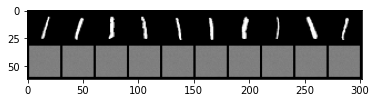

In [103]:
'''check outlier reconstruction'''
test_data = torch.stack([out_test_dl.dataset[i][0] for i in range(10)])
recon = model.reconstruct(test_data.reshape(-1,784).cuda(device)).detach().cpu()
recon = torch.clamp(recon.view(len(recon), 1, 28, 28), 0, 1)
x_and_recon = torch.cat([test_data, recon])
img_grid = make_grid(x_and_recon.detach().cpu(), nrow=10, range=(0, 1))
plt.imshow(img_grid.cpu().numpy().transpose(1,2,0))

In [104]:
'''vs_whatever AUC'''
in_pred = predict(model, in_test_dl, device, flatten=True)
out_pred = predict(model, out_test_dl, device, flatten=True)
auc = roc_btw_arr(out_pred, in_pred)
print(f'[SNIP pruned Autoencoder][vs{leave_out} AUC]: {auc}')



[SNIP pruned Autoencoder][vs1 AUC]: 0.9920077222955195


In [105]:
import seaborn as sns

<AxesSubplot:ylabel='Density'>

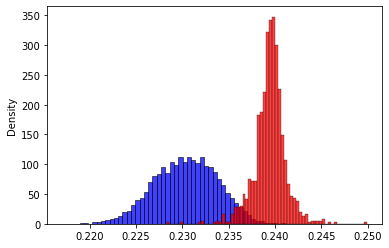

In [106]:
sns.histplot(in_pred,stat='density',color='b')
sns.histplot(out_pred,stat='density',color='r')

In [107]:
'''build model for RE loss weight training'''
encoder = FC_original_encode(device = device) #ConvNet2FC(1, z_dim, nh=8, nh_mlp=1024, out_activation='linear')
decoder = FC_original_decode(device = device) #DeConvNet2(z_dim, 1, nh=8, out_activation='sigmoid')
        
model = NAE(encoder, decoder)
model.cuda(device);

model.load_state_dict(torch.load(f'./snip_results/testing/sparsitiy_{sparsity}_leaveout_{leave_out}/ae_finetune.pkl'))

FileNotFoundError: [Errno 2] No such file or directory: './snip_results/testing/sparsitiy_0.9999_leaveout_1/ae_finetune.pkl'

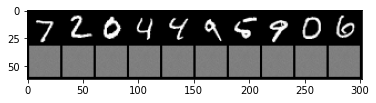

In [108]:
'''check inlier reconstruction'''
test_data = torch.stack([in_test_dl.dataset[i][0] for i in range(10)])
recon = model.reconstruct(test_data.reshape(-1,784).cuda(device)).detach().cpu()
recon = torch.clamp(recon.view(len(recon), 1, 28, 28), 0, 1)
x_and_recon = torch.cat([test_data, recon])
img_grid = make_grid(x_and_recon.detach().cpu(), nrow=10, range=(0, 1))
# writer.add_image('ae/inlier_recon', img_grid, 1)
plt.imshow(img_grid.cpu().numpy().transpose(1,2,0))

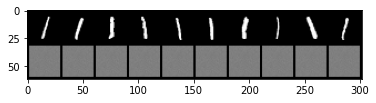

In [109]:
'''check outlier reconstruction'''
test_data = torch.stack([out_test_dl.dataset[i][0] for i in range(10)])
recon = model.reconstruct(test_data.reshape(-1,784).cuda(device)).detach().cpu()
recon = torch.clamp(recon.view(len(recon), 1, 28, 28), 0, 1)
x_and_recon = torch.cat([test_data, recon])
img_grid = make_grid(x_and_recon.detach().cpu(), nrow=10, range=(0, 1))
plt.imshow(img_grid.cpu().numpy().transpose(1,2,0))

In [93]:
'''vs_whatever AUC'''
in_pred = predict(model, in_test_dl, device, flatten=True)
out_pred = predict(model, out_test_dl, device, flatten=True)
auc = roc_btw_arr(out_pred, in_pred)
print(f'[SNIP pruned Autoencoder][vs{leave_out} AUC]: {auc}')




[SNIP pruned Autoencoder][vs1 AUC]: 0.2853371795731866
